In [32]:
import matplotlib.pyplot as plt
from os import getcwd
import torch
from numpy import linspace, logspace, savetxt, column_stack
from tqdm import tqdm
from torch.distributions import multivariate_normal

from algorithm_package.algorithm_package import paper_algorithm
from energy_package.energy_package import two_param
from rf_package.rf_package import planar_flow
from plot_animation_package.plot_animation_package import density_2D

import multiprocessing
from joblib import Parallel, delayed

In [33]:
def plot(beta, U, energy_parameters, model_file, renormalization_flow, base_distribution):

    flow = renormalization_flow
    flow.load_state_dict(torch.load(model_file+'\\model.pt'))
    flow.eval()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

    xlim = [-15,15]
    ylim = xlim
    x = torch.linspace(* xlim,200)
    y = torch.linspace(*ylim,200)

    xx, yy = torch.meshgrid(x,y)

    def log_rho_hat(x):
        return base_distribution.log_prob((flow.inverse(x))[0]) + flow.inverse(x)[1]

    z_flow = torch.exp(log_rho_hat(torch.stack([xx, yy], dim=-1).reshape(-1, 2)).detach()).reshape(xx.shape)
    z_flow_norm = z_flow / torch.sum(z_flow)+1e-15
    
    ax1.pcolormesh(xx.numpy(),yy.numpy(),z_flow_norm.numpy())
    ax1.set_title('Flow distribution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    z_target = torch.exp(-beta*U(torch.stack([xx, yy]), energy_parameters))
    z_target_norm = z_target / torch.sum(z_target)+1e-15
    
    ax2.pcolormesh(xx.numpy(),yy.numpy(),z_target_norm.numpy())
    ax2.set_title('Target distribution')
    ax2.set_xlabel('x')

    # Compute KL Divergence
    kl_div = torch.sum(z_flow_norm * torch.log(z_flow_norm / z_target_norm))
    
    fig.savefig(model_file+'.png')

    return kl_div

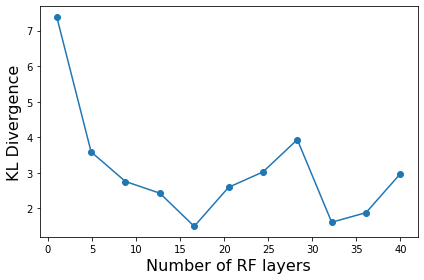

In [35]:
torch.manual_seed(0)
layer_list = linspace(1, 40, 11)

# MODEL PARAMETERS
data_dim = 2 #size of the parameter space
beta = 1
U = two_param.bistable_circle
BC = two_param.bistable_circle_BC
energy_parameters = []

# RF PARAMETERS
base_distribution = multivariate_normal.MultivariateNormal(loc=torch.zeros(data_dim), covariance_matrix=torch.eye(data_dim))
renormalization_flow = planar_flow.LayeredPlanarFlow(data_dim)
epsilon = 2e-2 #gradient descent rate for RF parameters
n = 200 #number of initial samples

# MALA PARAMETERS
time_step = 1e-1
k_lang = 10
k_max = 200

# INITIALISATION
initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*20-10

base_file = 'multivariate_normal-LayeredPlanarFlow-layer'

def computation(layer):
    layer = int(layer)
    model_name = base_file+"\\layer"+'{}'.format(layer)
    model_file = getcwd()+"\\saved_models"+"\\"+model_name
    RF_MCMC_parameters = [time_step, k_max, k_lang, epsilon]
    history, array_of_model_configurations = paper_algorithm.NF_MCMC_algorithm(model_name, beta, U, BC, energy_parameters, renormalization_flow, initial_data, base_distribution, *RF_MCMC_parameters)
    
    kl_div = plot(beta, U, energy_parameters, model_file, renormalization_flow, base_distribution)
    return kl_div

num_cores = multiprocessing.cpu_count()
with Parallel(n_jobs=num_cores) as parallel:
    kl_div_list = parallel(delayed(computation)(layer) for layer in layer_list)

txt_file = getcwd()+"\\saved_models"+"\\"+base_file+"\\layer.txt"
savetxt(txt_file, column_stack((layer_list, kl_div_list)), delimiter="\t", header="layer\tkl_div")

fig, ax = plt.subplots()

ax.set_xlabel('Number of RF layers', fontsize=16)
ax.set_ylabel('KL Divergence', fontsize=16)
ax.scatter(layer_list, kl_div_list)
ax.plot(layer_list, kl_div_list)
plt.tight_layout()
fig.savefig(getcwd()+"\\saved_models"+"\\"+base_file+'\\layer')